# Alan Precal

By "precal" we mean, for the default number of calibration terms (6, 5), figuring out the best S11 bias models that retrieve similar parameters to B18.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from edges_cal import modelling as mdl
from pathlib import Path

import mcmc_utils as mutl
from edges_estimate.eor_models import AbsorptionProfile
from edges_estimate.fitting import SemiLinearFit
from getdist import plots

import alan_data_utils as utils
import alan_data as adata
import glob
import run_alan_precal_mcmc as precal
from scipy import optimize
import notebook_utils as nutl
import pickle
from multiprocessing import Pool
import matplotlib.text as mtext

plt.ion()

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
nutl.setup_mpl()

In [3]:
calobs16 = utils.get_calobs(smooth=16)
calobs32 = utils.get_calobs(smooth=32)

In [4]:
names = sorted(Path('outputs/alan_precal/').glob("*"))

lks = {}
for name in names:
    print(name.name)
    lks[name.name] = precal.mcdef.get_likelihood_from_label(name.name)

smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale01_ndelay01_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale01_ndelay02_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale01_ndelay03_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale01_ndelay04_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale02_ndelay01_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale02_ndelay02_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale03_ndelay01_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale03_ndelay03_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale04_ndelay01_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale04_ndelay04_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open', 'ambient', 'hot_load')_nscale01_ndelay01_unw-False_cnf1
smooth32_tns0500_ign

In [5]:
params = {name.name: precal.mcdef.get_kwargs(name.name) for name in names}

In [6]:
optres = {}
for name in names:
    fname = name / 'bayescal.map'
    if fname.exists():
        with open(fname, 'rb') as fl:
            d = pickle.load(fl)
        thisopt = optres[name.name] = d['optres']
        
        if not thisopt.success:
            print(name.name, f" was not successful: {thisopt.message}")

In [7]:
optx = {name: res.x for name, res in optres.items()}

In [8]:
chains = mutl.get_completed_mcsamples(precal.mcdef.folder)

outputs/alan_precal/smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale01_ndelay01_unw-False_cnf1/bayescal.txt
Removed no burn in
outputs/alan_precal/smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale01_ndelay02_unw-False_cnf1/bayescal.txt
Removed no burn in
outputs/alan_precal/smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale01_ndelay03_unw-False_cnf1/bayescal.txt
Removed no burn in
outputs/alan_precal/smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale01_ndelay04_unw-False_cnf1/bayescal.txt
Removed no burn in
outputs/alan_precal/smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale02_ndelay01_unw-False_cnf1/bayescal.txt
Removed no burn in
outputs/alan_precal/smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale02_ndelay02_unw-False_cnf1/bayescal.txt
Removed no burn in
outputs/alan_precal/smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale03_ndelay01_unw-False_cnf1/bayescal.txt
Removed no burn in
outputs/alan_precal/smooth3

In [9]:
map_curves = {
    name: lks[name].get_cal_curves(res.x) for name, res in optres.items()
}

In [10]:
mean_curves = {
    name: lks[name].get_cal_curves(chain.getMeans()[:len(lks[name].partial_linear_model.child_active_params)]) for name, chain in chains.items()
}

In [11]:
meanx = {name: chain.getMeans()[:len(lks[name].partial_linear_model.child_active_params)] for name, chain in chains.items()}

In [12]:
mlx = {name: chain.samples[np.argmax(-chain.loglikes)][:len(lks[name].partial_linear_model.child_active_params)] for name, chain in chains.items()}

In [13]:
ml_curves = {
    name: lks[name].get_cal_curves(mlx[name]) for name, chain in chains.items()
}

In [14]:
def get_recals(pt_ests):
    recals = {}

    recals['alan'] = adata.sky_data['t_ant']

    for name, clb in (('Iterative (8ch)', utils.calobs), ("Iterative (32ch)", calobs32)):
        recals[name] = utils.recalibrate(utils.get_labcal(clb), f_sky=adata.sky_data['freq'], t_sky=adata.sky_data['t_ant'])

    for name, resx in pt_ests.items():
        lk = lks[name]
        a, b = lk.get_linear_coefficients(
            freq=adata.sky_freq, labcal=utils.labcal, params=resx
        )
        recals[name] = utils.recalibrate(utils.labcal, f_sky=adata.sky_data['freq'], t_sky=adata.sky_data['t_ant'], a=a,b=b)
        
    return recals

In [15]:
map_recals = get_recals(optx)

In [16]:
mean_recals = get_recals(meanx)

In [17]:
ml_recals = get_recals(mlx)

In [18]:
def get_slf(recal):
    linlog5 = mdl.LinLog(n_terms=5)
    return SemiLinearFit(
        fg=linlog5.at(x=adata.sky_freq), 
        eor=utils.make_absorption(adata.sky_freq),
        spectrum=recal, 
        sigma=0.03
    )
def get_features(recal):
    slf = get_slf(recal)
    return slf(dual_annealing_kw={'maxiter':200})

In [19]:
p = Pool(16)

In [20]:
# Don't change this, it's finnicky with multiprocessing.
map_features = dict(zip(map_recals.keys(), list(p.map(get_features, list(map_recals.values())))))
map_slfs = {name: get_slf(recal) for name, recal in map_recals.items()}

In [38]:
# Don't change this, it's finnicky with multiprocessing.
mean_features = dict(zip(mean_recals.keys(), list(p.map(get_features, list(mean_recals.values())))))
mean_slfs = {name: get_slf(recal) for name, recal in mean_recals.items()}

In [39]:
ml_features = dict(zip(ml_recals.keys(), list(p.map(get_features, list(ml_recals.values())))))
ml_slfs = {name: get_slf(recal) for name, recal in ml_recals.items()}

In [23]:
def plot_cal_params(filt, pt_est='map', labelmaker=lambda lbl, p: lbl):
    fig, ax = plt.subplots(5, 2, sharex=True, figsize=(nutl.double_width, 1.5*nutl.single_width), gridspec_kw={'hspace': 0.05, 'wspace': 0.35})

    ignore = []

    if pt_est == 'map':
        recals = map_recals
        curves= map_curves
        features = map_features
        slfs = map_slfs
    elif pt_est == 'mean':
        recals = mean_recals
        curves = mean_curves
        features = mean_features
        slfs = mean_slfs
    elif pt_est == 'ml':
        recals = ml_recals
        curves = ml_curves
        features = ml_features
        slfs = ml_slfs
        
    linestyles = ['-', '-'] + [(0, (i/2.0, 1)) for i in range(2,10)]

    for i, (name, model) in enumerate(list(curves.values())[0].items()):
        if name == 'params':
            continue

        if name == 'tload':
            aname = 'offset'
        elif name == 'tns':
            aname = 'scale'
        else:
            aname = name

        alans = adata.calibration[aname].copy()

        ylab = {
            'tunc': r'$T_{\rm unc}$',
            'tcos': r'$T_{\rm cos}$',
            'tsin': r'$T_{\rm sin}$',
            'tload': r"$T'_{\rm L}$",
            'tns': r"$T'_{\rm NS}$"
        }[name]
        ax[i, 0].text(0.8, 0.2 if i!=3 else 0.7, ylab, transform=ax[i, 0].transAxes, 
                      fontweight='heavy', backgroundcolor='white', 
                      bbox={'alpha': 0.5, 'facecolor': 'white', 'edgecolor': 'white', 'boxstyle':'round'})
        calobs_name = {
            'tunc': 'Tunc',
            'tcos': 'Tcos',
            'tsin': 'Tsin',
            'tload': 'C2',
            'tns': 'C1'
        }[name]

        v = getattr(utils.calobs, calobs_name)()
        v32 = getattr(calobs32, calobs_name)()

        if calobs_name == 'C2':
            v = utils.calobs.t_load - v
            v32 = utils.calobs.t_load - v32
            alans = utils.calobs.t_load - alans
        if calobs_name == 'C1':
            v *= utils.calobs.t_load_ns
            v32 *= utils.calobs.t_load_ns
            alans *= utils.calobs.t_load_ns

        all_curves = (('Iterative', v), ("Iterative (32ch)", v32)) + tuple(curves.items())
        n = 0
        for j, (lbl, crv) in enumerate(all_curves):
            p = params.get(lbl, {})
            if filt(lbl, p):
                continue

            label = labelmaker(lbl, p)
            if isinstance(crv, dict):
                m = crv[name]
            else:
                m = crv

            freq = utils.calobs.freq.freq

            if '32' in lbl:
                a = alans[::4]
                f = freq[::4].copy()
            else:
                a = alans
                f = freq.copy()

            lw = 1 if "8ch" in label else 2
            
            ax[i, 0].plot(f, 100*(m - a)/a, label=label, ls=linestyles[n%len(linestyles)], color=f'C{j%10}', lw=lw)
            n += 1
    linlog5 = mdl.LinLog(n_terms=5)

    n = 0
    for i, (name, recal) in enumerate(recals.items()):
        p = params.get(name, {})
        if filt(name, p):
            continue

        color = 'k' if not i else f"C{(i-1)%10}"
        ls=linestyles[(n-1)%len(linestyles)] if i > 0 else '-'
        lw = 1 if "8ch" in label else 2
        
        if name != 'alan':
            ax[-2, 1].plot(adata.sky_freq, recal - adata.sky_data['t_ant'], color=color, ls=ls)

        res, slf = features[name], slfs[name]
        if not res.success:
            print(i, "was not successful")

        ax[-1, 1].plot(adata.sky_freq, slf.get_eor(res.x), color=color, ls=ls, lw=4 if name=='alan' else lw, label='B18' if name == 'alan' else None, )
        n += 1
        
    ax[0, 1].axis('off')
    ax[1, 1].axis('off')
    ax[2, 1].axis('off')

    ax[-1, 1].set_ylabel(r"$\hat{T}_{21}$ [K]")

    # fig.text(0.04, 2.5/7, )
    #plt.annotate(r'$\Delta T / T^{\rm B18}$', va='center', rotation='vertical', xytext=(0.04, 2.5/7), xy=(0.04, 1), transform=fig.transFigure)
    ax[-2, 1].set_ylabel(r"$\Delta T_{\rm sky}$ [K]")
    
    h,l = ax[0,0].get_legend_handles_labels()

    class LegendTitle:
        # ripped from here: https://stackoverflow.com/questions/38463369/subtitles-within-matplotlib-legend
        def __init__(self, text_props=None):
            self.text_props = text_props or {}
            super(LegendTitle, self).__init__()

        def legend_artist(self, legend, orig_handle, fontsize, handlebox):
            x0, y0 = handlebox.xdescent, handlebox.ydescent
            title = mtext.Text(x0, y0, orig_handle,  **self.text_props)
            handlebox.add_artist(title)
            return title

    
    ax[0, 0].legend(
        ['Iterative Solutions'] + h[:2] + ['','Max-Likelihood (32ch)'] + h[2:], 
        ['']         + l[:2] + ['','']          + l[2:],
        handler_map={str: LegendTitle({'fontsize': 10})},
        ncol=1, bbox_to_anchor=(1.3, 1.), loc='upper left',
        frameon=False
    )
    ax[-1, 1].legend(loc='lower left', frameon=False)
    ax[-1, 1].set_xlabel("Frequency [MHz]")
    ax[-1, 0].set_xlabel("Frequency [MHz]")

    fig.supylabel(r"$\Delta T / T^{\rm B18}$ [%]")
    plt.tight_layout()

/tmp/ipykernel_11127/2394856905.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


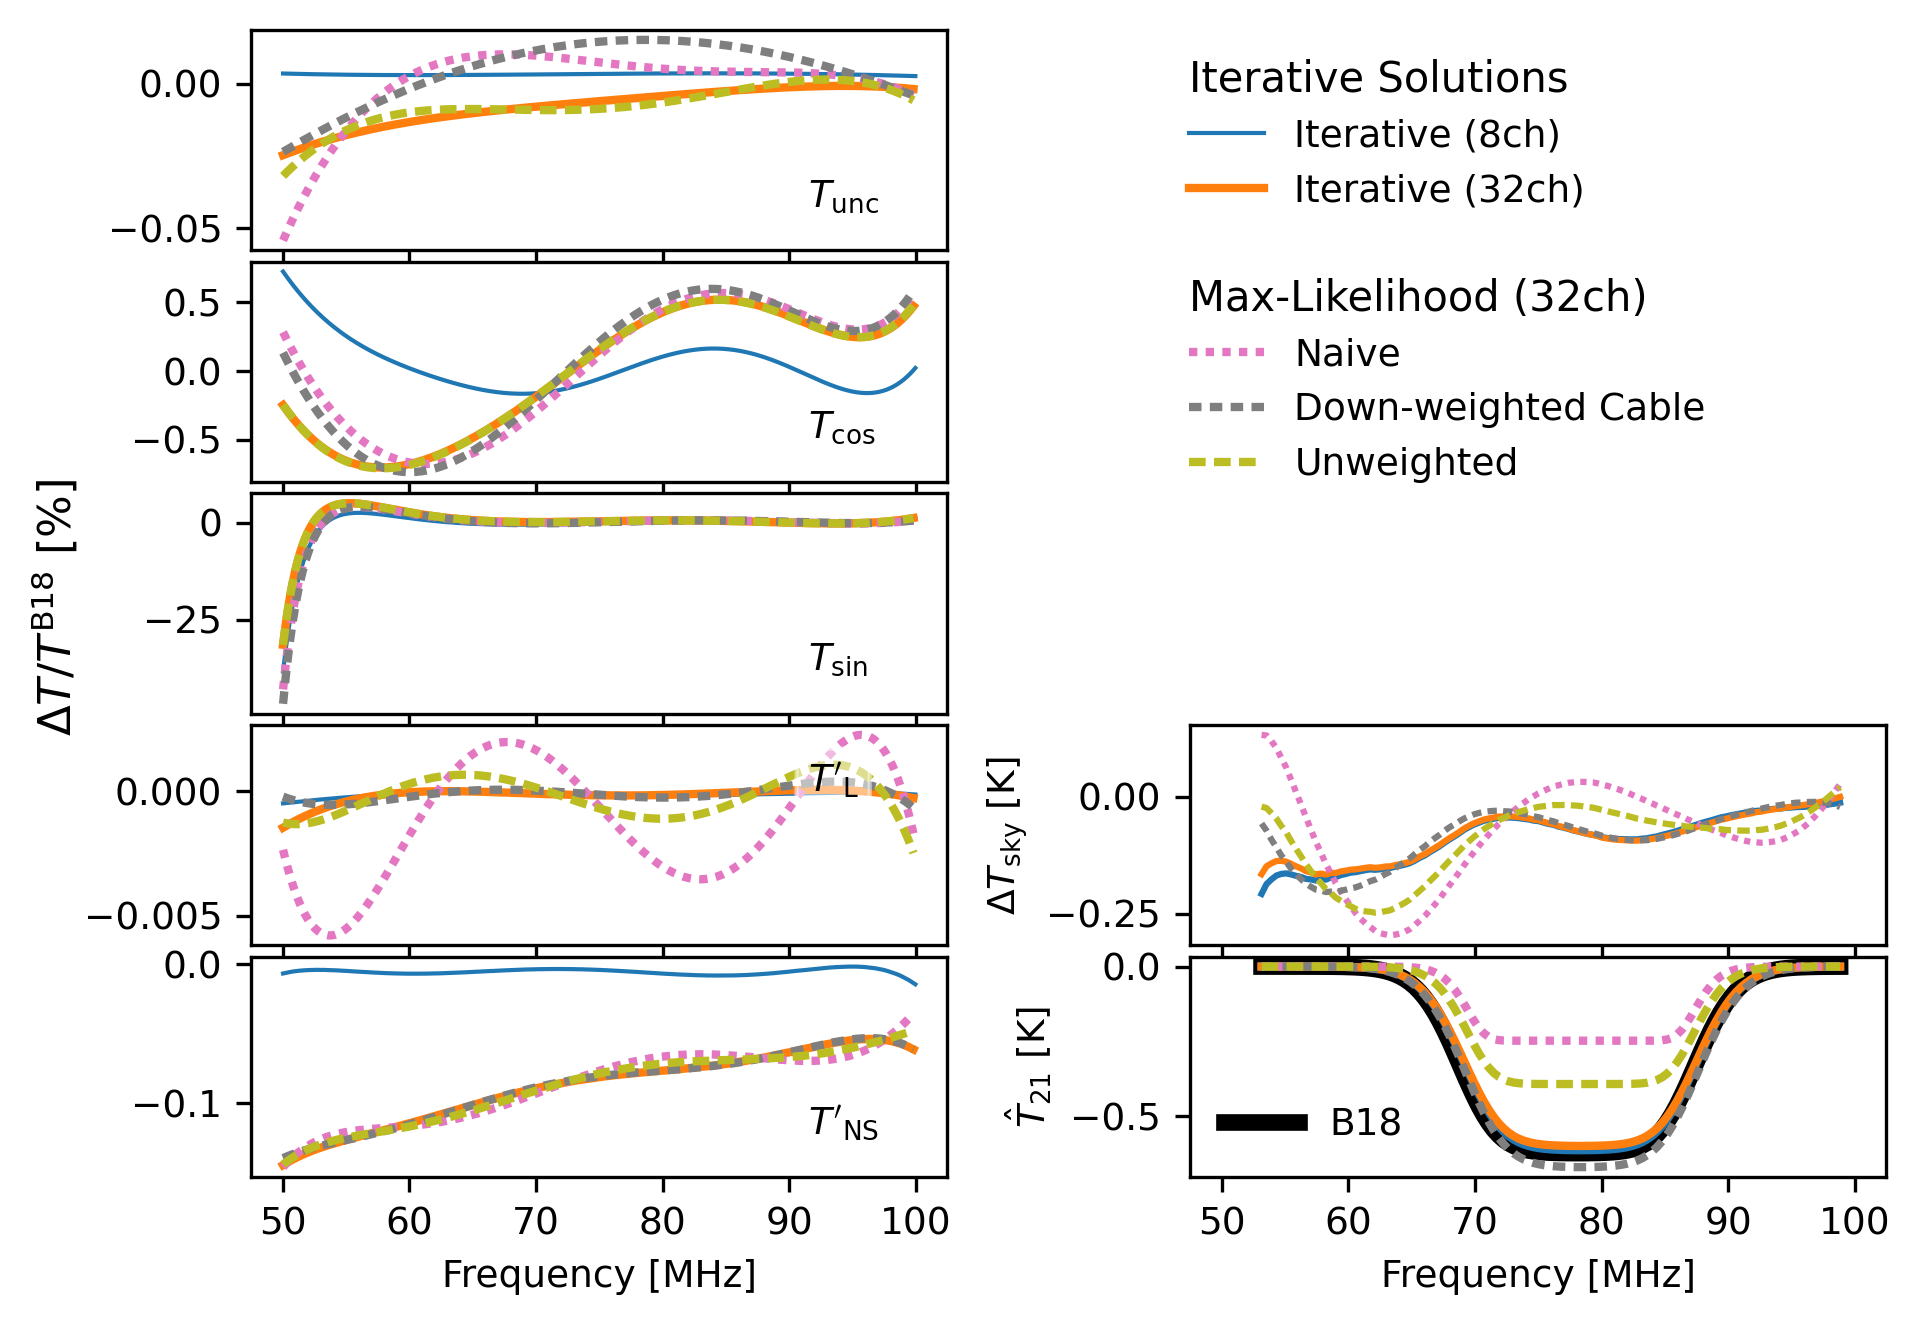

In [24]:
plot_cal_params(
    lambda lbl, p: p.get('s11_sys', False), 
    pt_est='map',
    labelmaker=lambda lbl, p: (lbl+" (8ch)" if 'ch' not in lbl else lbl) if not p else ('Unweighted' if p['unweighted'] else 'Down-weighted Cable' if p['cable_noise_factor']>1 else "Naive")
)
plt.savefig("plots/differences_with_alan.pdf")

In [12]:
antsim = calobs32.new_load('AntSim1', io_obj = utils.calobs.metadata['io'])

In [73]:
these_loads = {**calobs32.loads, **{'antsim': antsim}}

In [83]:
def residual_plot(pt_est, filt, labelmaker, include_antsim=True):
    loads = {k: v for k,v in these_loads.items()}
    if not include_antsim:
        del loads['antsim']
        
    fig, ax = plt.subplots(len(loads), 1, figsize=(1.5*nutl.single_width, 1.8*nutl.single_width), sharex=True, gridspec_kw={'hspace': 0.05}, constrained_layout=True)

    n = 0
    
    # First, plot the default solution
    for i, (src, load) in enumerate(loads.items()):
        res = calobs32.calibrate(load) - load.temp_ave
        ax[i].plot(calobs32.freq.freq, res, label='Iterative', color=f'k')

        ax[i].text(0.42, 0.85, "RMS [mK]: ", transform=ax[i].transAxes, horizontalalignment='right')
        ax[i].text(0.45 + n*0.15, 0.85, f"{np.sqrt(np.mean(np.square(res)))*1000:.1f}", color=f"k", transform=ax[i].transAxes)

        tns = calobs32.C1()*calobs32.t_load_ns
        res2 = res / np.sqrt(load.spectrum.variance_Q / load.spectrum.n_integrations) / tns

        
        ax[i].text(0.42, 0.05, "RMS [$\sigma$]: ",transform=ax[i].transAxes, horizontalalignment='right')
        ax[i].text(0.45 + n*0.15, 0.05, f"{np.sqrt(np.mean(np.square(res2))):.2f}", color=f"k", transform=ax[i].transAxes)

        ax[i].set_ylabel(src)
            
    n = 1
    
    for j, (name, resx) in enumerate(pt_est.items()):
        p = params.get(name, {})
        lk = lks[name]
        
        if filt(name, p):
            continue
            
        for i, (src, load) in enumerate(loads.items()):
            a, b = lk.get_linear_coefficients(
                freq=calobs32.freq.freq.to_value("MHz"), labcal=utils.get_labcal(calobs32), params=resx, load=load
            )

            cal = calobs32.t_load_ns * a * load.spectrum.averaged_Q + a * 300 + b

            res = cal - load.temp_ave
            ax[i].plot(calobs32.freq.freq, res, label=labelmaker(name,p), alpha=0.6, color=f'C{j+2}')

                
            ax[i].text(0.45 + n*0.15, 0.85, f"{np.sqrt(np.mean(np.square(res)))*1000:.1f}", color=f"C{j+2}", transform=ax[i].transAxes)

            tns = lk.t_ns_model.model(parameters=resx[:calobs32.cterms])
            res2 = res / np.sqrt(load.spectrum.variance_Q / load.spectrum.n_integrations) / tns

            ax[i].text(0.45 + n*0.15, 0.05, f"{np.sqrt(np.mean(np.square(res2))):.2f}", color=f"C{j+2}", transform=ax[i].transAxes)
        

        n += 1

    ax[0].legend(ncol=2, bbox_to_anchor=(0,0.77, 0, 0.77), loc="upper left", frameon=False)
    ax[-1].set_xlabel("Frequency [MHz]")
    # plt.tight_layout()


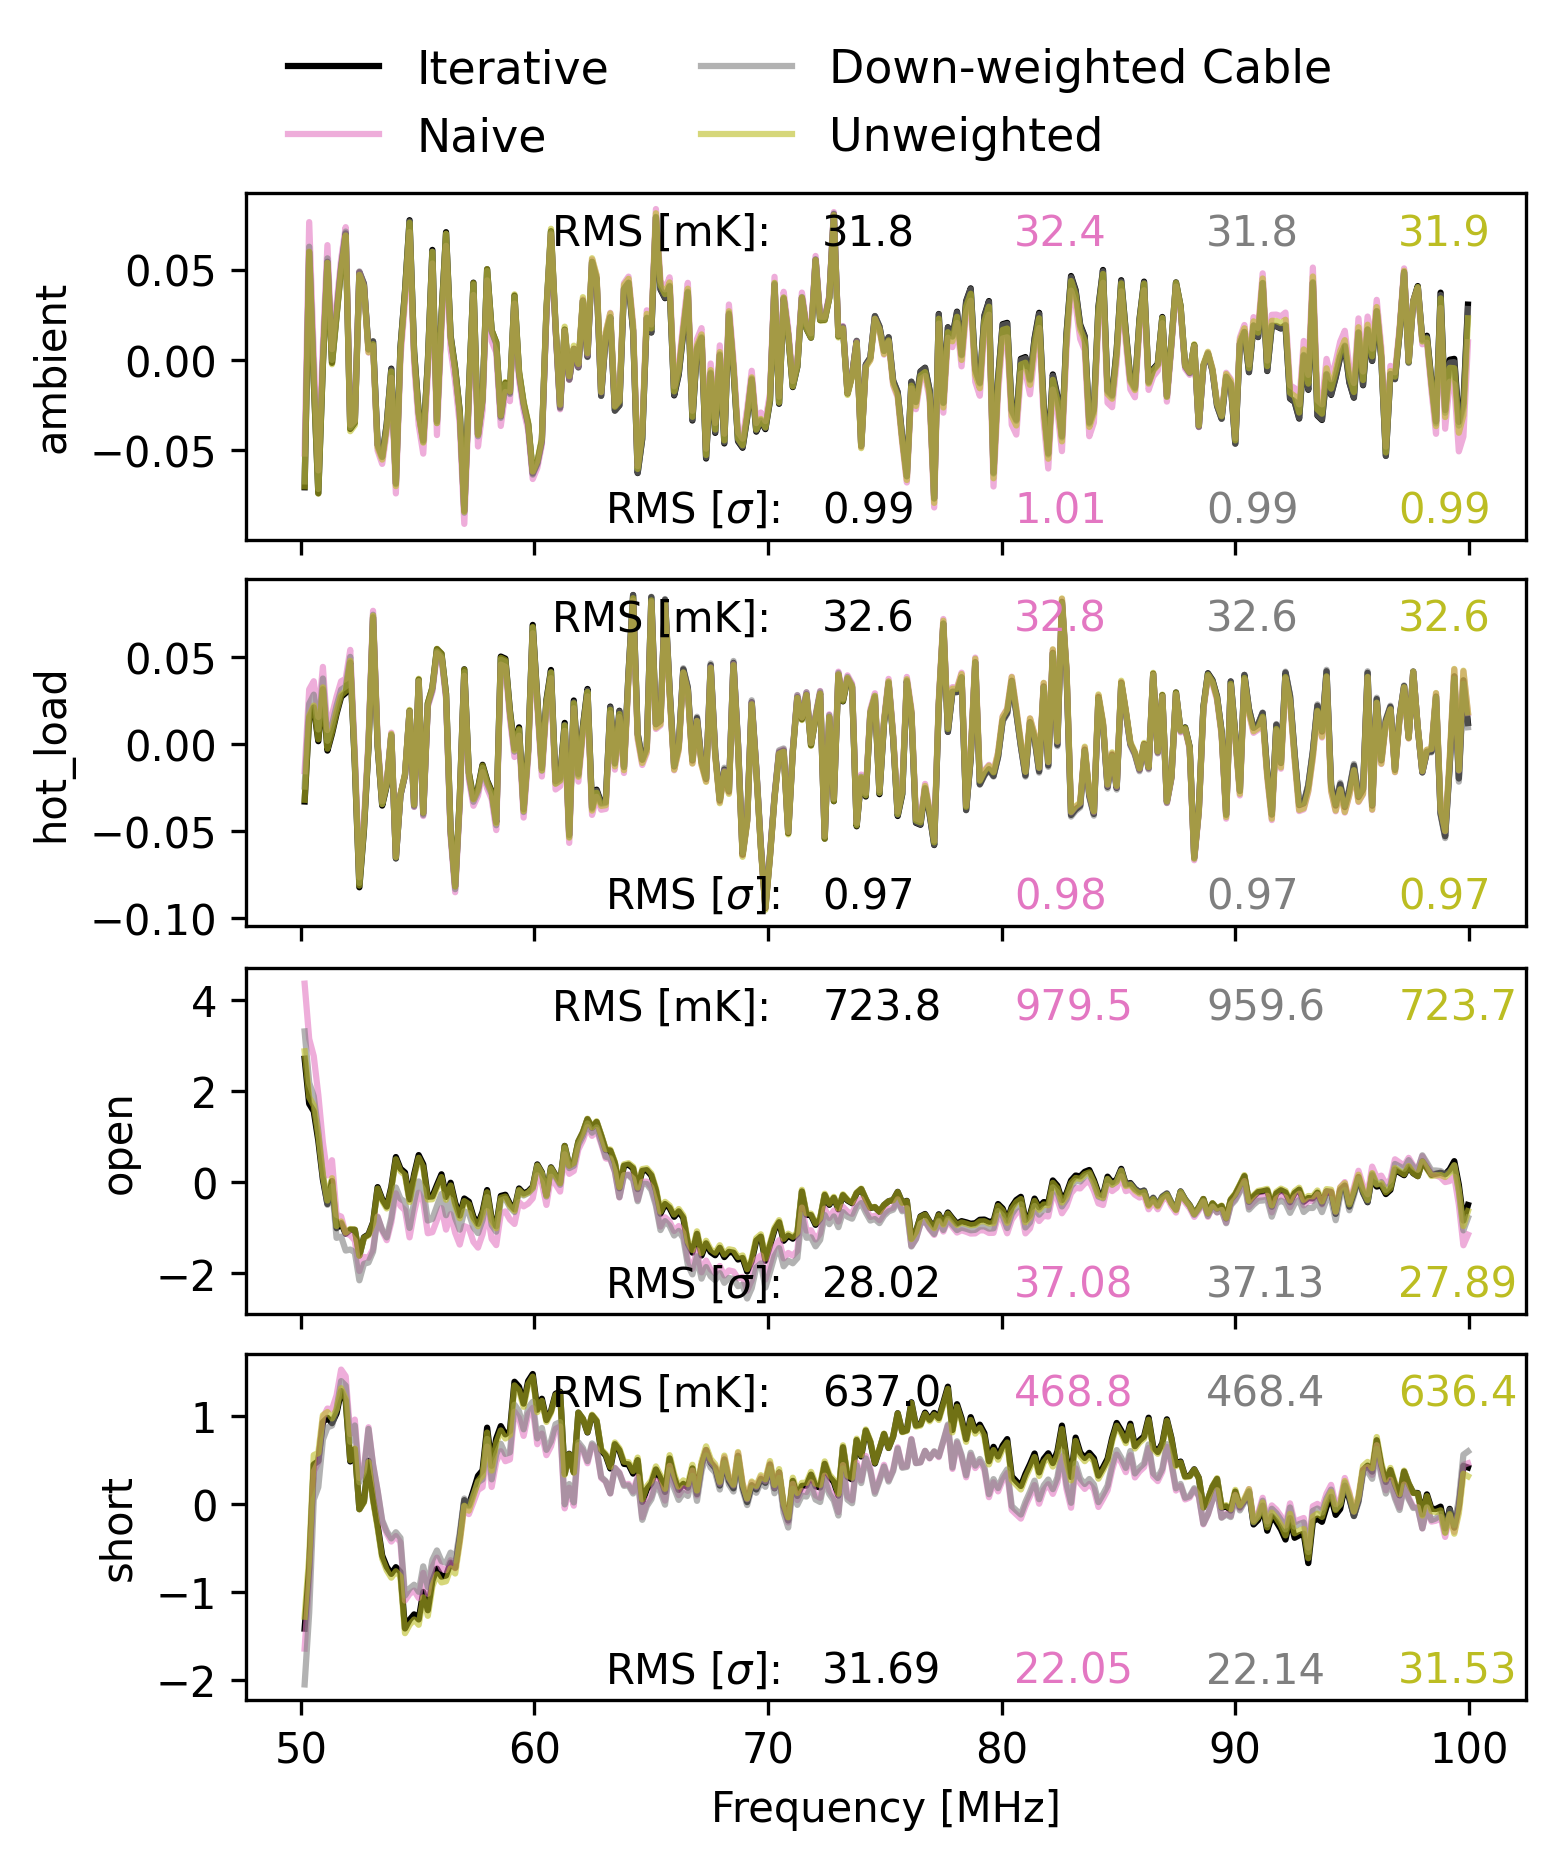

In [84]:
residual_plot(
    optx, 
    lambda lbl, p: p.get('s11_sys', False), 
    labelmaker=lambda lbl, p: lbl if not p else ('Unweighted' if p['unweighted'] else 'Down-weighted Cable' if p['cable_noise_factor']>1 else "Naive"),
    include_antsim=False
)
plt.savefig("plots/lab_resids.pdf")

In [6]:
recals_wterms = {}
for wterms in range(4, 9):
    recals_wterms[wterms] = utils.recalibrate(utils.get_labcal(utils.get_calobs(smooth=32, wterms=wterms)), f_sky=adata.sky_data['freq'], t_sky=adata.sky_data['t_ant'])

In [9]:
linlog5 = mdl.LinLog(n_terms=5)
wslfs = {
    w: SemiLinearFit(
        fg=linlog5.at(x=adata.sky_freq), 
        eor=utils.make_absorption(adata.sky_freq),
        spectrum=recal, 
        sigma=0.03
    ) for w, recal in recals_wterms.items()
}

In [10]:
wres = {w: slf(dual_annealing_kw={'maxiter':200}) for w, slf in wslfs.items()}

In [ ]:
fig, ax = plt.subplots(6, 1, figsize=(1.5*nutl.single_width, 2.5*nutl.single_width), sharex=True)

n = 0

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#dede00', 
                  '#a65628', '#984ea3',
                  '#e41a1c',  '#999999',]
lss = ['--'] + ['-']*100

for wterms in range(4, 9):
    clb = utils.get_calobs(smooth=32, wterms=wterms)
    
    these_loads = {**clb.loads, **{'antsim': antsim}}
    for i, (src, load) in enumerate(these_loads.items()):
        res = clb.calibrate(load) - load.temp_ave
        ax[i].plot(clb.freq.freq, res, color=CB_color_cycle[n], ls = lss[n%len(lss)])

        ax[i].text(0.25, 0.85, "RMS [mK]: ", transform=ax[i].transAxes, horizontalalignment='right')
        ax[i].text(0.28 + n*0.15, 0.85, f"{np.sqrt(np.mean(np.square(res)))*1000:.1f}", color=CB_color_cycle[n], transform=ax[i].transAxes)

        tns = clb.C1()*clb.t_load_ns
        res2 = res / np.sqrt(load.spectrum.variance_Q / load.spectrum.n_integrations) / tns


        ax[i].text(0.25, 0.05, "RMS [$\sigma$]: ",transform=ax[i].transAxes, horizontalalignment='right')
        ax[i].text(0.28+ n*0.15, 0.05, f"{np.sqrt(np.mean(np.square(res2))):.2f}", color=CB_color_cycle[n], transform=ax[i].transAxes)

        ax[i].set_ylabel(src)
    
    
    recal = utils.recalibrate(utils.get_labcal(clb), f_sky=adata.sky_data['freq'], t_sky=adata.sky_data['t_ant'])
    linlog5 = mdl.LinLog(n_terms=5)
    slf = wslfs[wterms]
    res = wres[wterms] #slf(dual_annealing_kw={'maxiter':200})
    ax[-1].plot(adata.sky_freq, slf.get_eor(res.x), label=str(wterms), color=CB_color_cycle[n], ls = lss[n%len(lss)],)
    ax[-1].set_xlabel("Frequency [MHz]")
    n += 1

ax[-1].set_ylabel(r"$\hat{T}_{21}$")
ax[-1].legend(ncol=2, labelspacing=0.25, handletextpad=0.5, columnspacing=1.5, handlelength=1.4, frameon=False, loc='lower left')

plt.tight_layout()
plt.savefig("plots/wterms_residuals.pdf")